## 1. importing packages

In [1]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import datetime as dt
import pandas_datareader as web
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import matplotlib.ticker as ticker
import itertools

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from tensorflow.keras.callbacks import History, EarlyStopping
from tensorflow.keras import optimizers

import keras_tuner as kt
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint


## 2. overall configurations

In [2]:
%matplotlib inline


tqdm.pandas()
sns.set(style='whitegrid',palette='muted')
rcParams['figure.figsize'] = 14, 10

## 3. Getting the Data

In [3]:
import yfinance as yf
ticket = yf.Ticker('BOVA11.SA')
start = dt.datetime(2009, 1, 2) # First register data
end = dt.datetime(dt.datetime.now().year,dt.datetime.now().month,dt.datetime.now().day - 2)

bova11 = ticket.history(interval= '1d', start = start, end = end).reset_index()
bova11
bova11_copy = bova11.copy()

In [4]:
len(bova11)

3487

## 4. Pre-processing

Adjust the columns name and type

In [5]:
bova11.columns = bova11.columns.str.lower()

In [6]:
bova11.date = pd.to_datetime(bova11.date)

In [7]:
bova11.isna().sum()

date            0
open            0
high            0
low             0
close           0
volume          0
dividends       0
stock splits    0
dtype: int64

Removing rows with volume 0

In [8]:
bova11 = bova11.loc[(bova11.volume != 0)].reset_index()
bova11.drop(columns='index', axis = 1, inplace = True)
bova11

,date,open,high,low,close,volume,dividends,stock splits
0,2009-01-02 00:00:00-02:00,38.279999,40.320000,37.939999,40.320000,119900,0,0
1,2009-01-05 00:00:00-02:00,40.200001,42.000000,39.700001,42.000000,341700,0,0
2,2009-01-06 00:00:00-02:00,42.060001,42.320000,41.549999,42.320000,178300,0,0
3,2009-01-07 00:00:00-02:00,41.750000,41.770000,40.450001,40.639999,73400,0,0
4,2009-01-08 00:00:00-02:00,40.150002,42.200001,40.150002,42.200001,195300,0,0
...,...,...,...,...,...,...,...,...
3389,2023-01-13 00:00:00-03:00,106.940002,107.639999,106.690002,107.349998,4742049,0,0
3390,2023-01-16 00:00:00-03:00,106.949997,106.949997,105.129997,105.470001,6905014,0,0
3391,2023-01-17 00:00:00-03:00,106.239998,107.980003,106.220001,107.800003,6647627,0,0
3392,2023-01-18 00:00:00-03:00,108.830002,109.599998,108.330002,108.330002,9405455,0,0


Sorting the data by date

In [9]:
bova11 = bova11.sort_values(by='date').reset_index(drop=True)

Adding a column with the previous close value

In [10]:
bova11["prev_close"] = bova11.shift(1)["close"]

In [11]:
bova11.head()

,date,open,high,low,close,volume,dividends,stock splits,prev_close
0,2009-01-02 00:00:00-02:00,38.279999,40.320000,37.939999,40.320000,119900,0,0,NaN
1,2009-01-05 00:00:00-02:00,40.200001,42.000000,39.700001,42.000000,341700,0,0,40.320000
2,2009-01-06 00:00:00-02:00,42.060001,42.320000,41.549999,42.320000,178300,0,0,42.000000
3,2009-01-07 00:00:00-02:00,41.750000,41.770000,40.450001,40.639999,73400,0,0,42.320000
4,2009-01-08 00:00:00-02:00,40.150002,42.200001,40.150002,42.200001,195300,0,0,40.639999


Adding the close difference between dates

In [12]:
bova11["close_change"]= bova11.progress_apply(
    lambda row: 0 if np.isnan(row.prev_close) else row.close - row.prev_close,
    axis = 1
)

100%|██████████| 3394/3394 [00:00<00:00, 13859.99it/s]


In [13]:
bova11.head()

,date,open,high,low,close,volume,dividends,stock splits,prev_close,close_change
0,2009-01-02 00:00:00-02:00,38.279999,40.320000,37.939999,40.320000,119900,0,0,NaN,0.000000
1,2009-01-05 00:00:00-02:00,40.200001,42.000000,39.700001,42.000000,341700,0,0,40.320000,1.680000
2,2009-01-06 00:00:00-02:00,42.060001,42.320000,41.549999,42.320000,178300,0,0,42.000000,0.320000
3,2009-01-07 00:00:00-02:00,41.750000,41.770000,40.450001,40.639999,73400,0,0,42.320000,-1.680000
4,2009-01-08 00:00:00-02:00,40.150002,42.200001,40.150002,42.200001,195300,0,0,40.639999,1.560001


Checking the dataseries over time

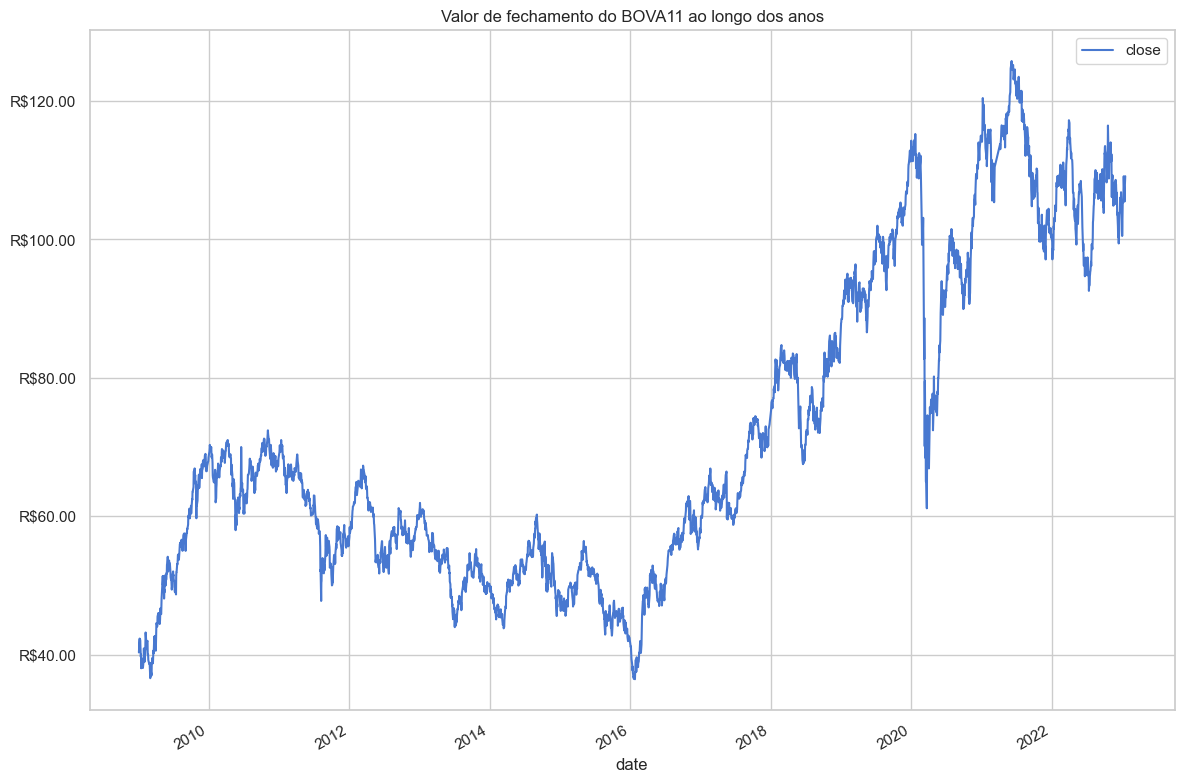

In [14]:
daily_closing = bova11[['date','close']]
daily_closing = daily_closing.set_index('date')
ax = daily_closing.plot()
plt.title('Valor de fechamento do BOVA11 ao longo dos anos')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("R${x:,.2f}"))

#### Feature Engineering
Add auxiliar columns that can improve our model, like moving averages,standard deviation, techinical indicators and others
Let's add:
- Moving_average for 3, 10, 30 and 60 days
- Standard deviation for 7, 30 and 60 days
- Bollinger limits for Upper and lowers 3, 30 and 60
- Add RSI indicator

In [15]:
# Adding move Averages columns
bova11['ma_3d'] = bova11['close'].rolling(3, center = True, min_periods=1).mean()
bova11['ma_10d'] = bova11['close'].rolling(10, center = True,min_periods=1).mean()
bova11['ma_30d'] = bova11['close'].rolling(30, center=True, min_periods=1).mean()
bova11['ma_60d'] = bova11['close'].rolling(60, center = True, min_periods = 1).mean()

In [16]:
# Adding standard deviation columns
bova11['std_7'] = bova11['close'].rolling(7, center = True, min_periods = 1).std()
bova11['std_30'] = bova11['close'].rolling(30, center = True, min_periods = 1).std()
bova11['std_60'] = bova11['close'].rolling(60, center = True, min_periods = 1).std()

In [17]:
# Adding the bollinger bands
bova11['upper3'] = bova11['ma_3d'] + 2*bova11['close'].rolling(3, center = True, min_periods = 1).std()
bova11['lower3'] = bova11['ma_3d'] - 2*bova11['close'].rolling(3, center = True, min_periods = 1).std()

bova11['upper30'] = bova11['ma_30d'] + 2*bova11['std_30']
bova11['lower30'] = bova11['ma_30d'] - 2*bova11['std_30']

bova11['upper60'] = bova11['ma_60d'] + 2*bova11['std_60']
bova11['lower60'] = bova11['ma_60d'] - 2*bova11['std_60']

In [18]:
# Adding tecnical indicator RSI
bova11['RSI'] = ta.rsi(bova11['close'], length = 15)

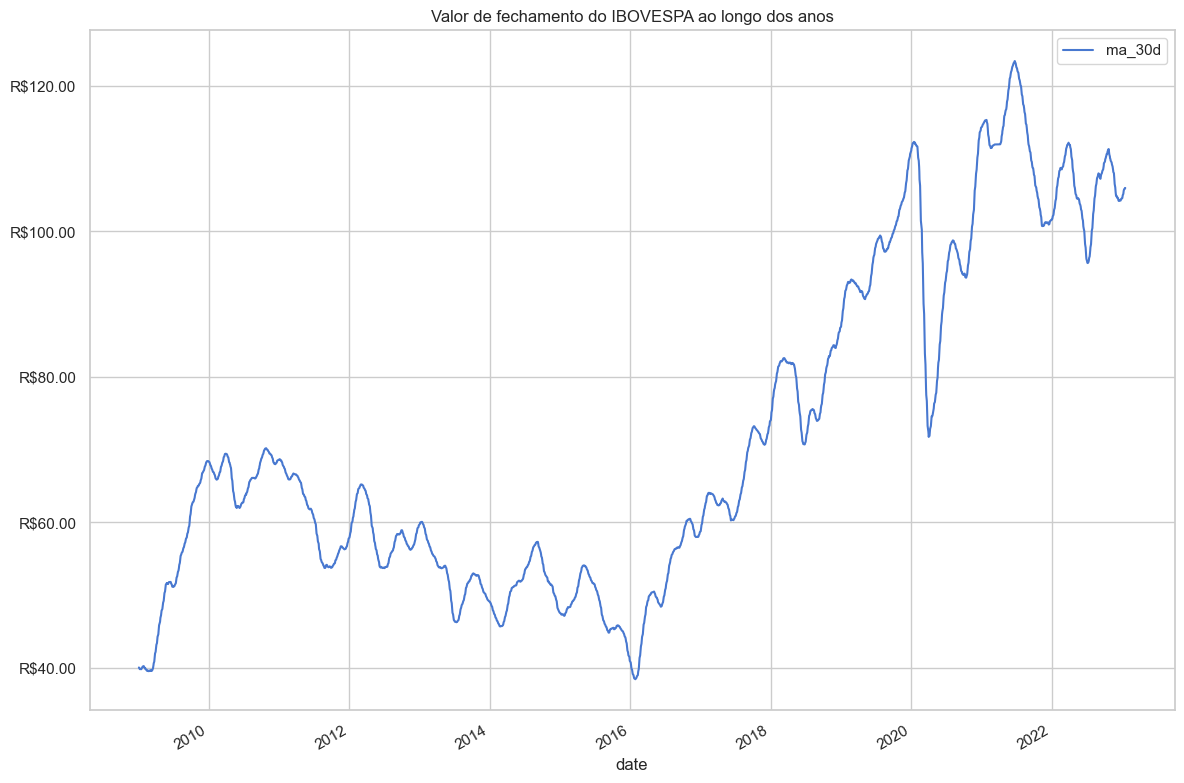

In [19]:
moving_avg = bova11[['date','ma_30d']]
moving_avg = moving_avg.set_index('date')
ax = moving_avg.plot()
plt.title('Valor de fechamento do IBOVESPA ao longo dos anos')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("R${x:,.2f}"))

Select the features and the predict columns

In [20]:
bova11.drop(['date', 'volume', 'dividends', 'stock splits', 'prev_close'],
            axis = 1,
           inplace = True)


In [21]:
bova11

,open,high,low,close,close_change,ma_3d,ma_10d,ma_30d,ma_60d,std_7,std_30,std_60,upper3,lower3,upper30,lower30,upper60,lower60,RSI
0,38.279999,40.320000,37.939999,40.320000,0.000000,41.160000,41.496000,40.072667,40.216334,0.987387,1.459904,1.394817,43.535879,38.784121,42.992476,37.152858,43.005967,37.426700,NaN
1,40.200001,42.000000,39.700001,42.000000,1.680000,41.546666,41.580000,39.948125,40.269033,0.941319,1.495795,1.402411,43.695279,39.398054,42.939715,36.956536,43.073854,37.464211,NaN
2,42.060001,42.320000,41.549999,42.320000,0.320000,41.653333,41.311429,39.892353,40.322813,0.866718,1.466439,1.412751,43.437411,39.869255,42.825231,36.959475,43.148315,37.497311,NaN
3,41.750000,41.770000,40.450001,40.639999,-1.680000,41.720000,41.147500,39.842223,40.313031,1.063445,1.438465,1.391637,43.594461,39.845539,42.719153,36.965292,43.096304,37.529757,NaN
4,40.150002,42.200001,40.150002,42.200001,1.560001,41.613333,40.801111,39.897895,40.303530,1.118613,1.418844,1.371508,43.311019,39.915647,42.735582,37.060208,43.046547,37.560513,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3389,106.940002,107.639999,106.690002,107.349998,-0.910004,107.026667,107.345000,105.774000,104.783143,1.156308,2.345566,2.732308,109.872319,104.181015,110.465132,101.082868,110.247759,99.318527,55.137312
3390,106.949997,106.949997,105.129997,105.470001,-1.879997,106.873334,107.550001,105.871053,104.716177,1.253923,2.368223,2.744089,109.345284,104.401385,110.607498,101.134608,110.204354,99.227999,50.240974
3391,106.239998,107.980003,106.220001,107.800003,2.330002,107.200002,107.825001,105.863889,104.618182,1.249128,2.436669,2.725552,110.242962,104.157042,110.737227,100.990551,110.069286,99.167079,55.489642
3392,108.830002,109.599998,108.330002,108.330002,0.529999,108.413335,107.917144,105.905882,104.586563,1.364888,2.504938,2.763007,109.731260,107.095410,110.915759,100.896006,110.112577,99.060548,56.605212


In [22]:
bova11['target'] = bova11.close - bova11.open
#bova11['targetClass'] = [1 if bova11.target[i] > 0 else 0 for i in range(len(bova11))]
bova11['targetNextClose'] = bova11['close'].shift(-1)

In [23]:
bova11

,open,high,low,close,close_change,ma_3d,ma_10d,ma_30d,ma_60d,std_7,...,std_60,upper3,lower3,upper30,lower30,upper60,lower60,RSI,target,targetNextClose
0,38.279999,40.320000,37.939999,40.320000,0.000000,41.160000,41.496000,40.072667,40.216334,0.987387,...,1.394817,43.535879,38.784121,42.992476,37.152858,43.005967,37.426700,NaN,2.040001,42.000000
1,40.200001,42.000000,39.700001,42.000000,1.680000,41.546666,41.580000,39.948125,40.269033,0.941319,...,1.402411,43.695279,39.398054,42.939715,36.956536,43.073854,37.464211,NaN,1.799999,42.320000
2,42.060001,42.320000,41.549999,42.320000,0.320000,41.653333,41.311429,39.892353,40.322813,0.866718,...,1.412751,43.437411,39.869255,42.825231,36.959475,43.148315,37.497311,NaN,0.259998,40.639999
3,41.750000,41.770000,40.450001,40.639999,-1.680000,41.720000,41.147500,39.842223,40.313031,1.063445,...,1.391637,43.594461,39.845539,42.719153,36.965292,43.096304,37.529757,NaN,-1.110001,42.200001
4,40.150002,42.200001,40.150002,42.200001,1.560001,41.613333,40.801111,39.897895,40.303530,1.118613,...,1.371508,43.311019,39.915647,42.735582,37.060208,43.046547,37.560513,NaN,2.049999,42.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3389,106.940002,107.639999,106.690002,107.349998,-0.910004,107.026667,107.345000,105.774000,104.783143,1.156308,...,2.732308,109.872319,104.181015,110.465132,101.082868,110.247759,99.318527,55.137312,0.409996,105.470001
3390,106.949997,106.949997,105.129997,105.470001,-1.879997,106.873334,107.550001,105.871053,104.716177,1.253923,...,2.744089,109.345284,104.401385,110.607498,101.134608,110.204354,99.227999,50.240974,-1.479996,107.800003
3391,106.239998,107.980003,106.220001,107.800003,2.330002,107.200002,107.825001,105.863889,104.618182,1.249128,...,2.725552,110.242962,104.157042,110.737227,100.990551,110.069286,99.167079,55.489642,1.560005,108.330002
3392,108.830002,109.599998,108.330002,108.330002,0.529999,108.413335,107.917144,105.905882,104.586563,1.364888,...,2.763007,109.731260,107.095410,110.915759,100.896006,110.112577,99.060548,56.605212,-0.500000,109.110001


In [24]:
bova11.dropna(inplace = True)

In [25]:
scaler = MinMaxScaler(feature_range = (-1, 1))
bova11_scaled = scaler.fit_transform(bova11)
print(bova11_scaled)

[[-0.41052802 -0.95937954 -0.97594966 ... -0.34158244 -0.812735
  -0.94288915]
 [-0.39380423 -0.93549828 -0.95100022 ... -0.1145866  -0.81635782
  -0.94311308]
 [-0.38663696 -0.9468809  -0.94178467 ... -0.11645738 -0.82917641
  -0.90033593]
 ...
 [ 0.7034323   0.56991398  0.55990106 ...  0.05444169 -0.8837953
   0.59798439]
 [ 0.69212389  0.59290263  0.58440103 ...  0.21208654 -0.79908022
   0.60985446]
 [ 0.73337584  0.6290592   0.63182744 ...  0.2455929  -0.85648596
   0.62732364]]


Select the features and prediction target columns

In [26]:
backcandles = 100
X = []
for j in range(19): # range is the number of feature columns you will use
    X.append([])
    for i in range(backcandles, bova11_scaled.shape[0]):
        X[j].append(bova11_scaled[i-backcandles:i, j])

#move axis from 0 to position 2
X = np.moveaxis(X, [0], [2])

X, yi = np.array(X), np.array(bova11_scaled[backcandles:, -1]) # Chosing the last column as the pred. target
y = np.reshape(yi, (len(yi), 1))

X.shape, y.shape

((3278, 100, 19), (3278, 1))

Split the train and test data

In [27]:
splitlimit = int(len(X) * 0.9)
X_train, X_test = X[:splitlimit], X[splitlimit+1:]
y_train, y_test = y[:splitlimit], y[splitlimit+1:]

In [28]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2950, 100, 19) (327, 100, 19) (2950, 1) (327, 1)


### 4. Creating the model

In [29]:
def create_lstm_model(backcandles, num_features, dropout_prob):
    model = Sequential()
    model.add(LSTM(64, input_shape = (backcandles, num_features)))
    model.add(Dropout(dropout_prob))
    model.add(Dense(1))
    adam = optimizers.Adam()
    model.compile(optimizer=adam, loss = 'mse')
    return model

In [30]:
model = create_lstm_model(100, 19, 0.1)
model.fit(x = X_train, y = y_train, batch_size = 16, epochs = 10, shuffle = True, validation_split = 0.1)

Epoch 1/10
166/166 [==============================] - 10s 41ms/step - loss: 0.0118 - val_loss: 0.0017
Epoch 2/10
166/166 [==============================] - 7s 39ms/step - loss: 0.0032 - val_loss: 0.0022
Epoch 3/10
166/166 [==============================] - 6s 39ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 4/10
166/166 [==============================] - 6s 38ms/step - loss: 0.0019 - val_loss: 0.0031
Epoch 5/10
166/166 [==============================] - 7s 39ms/step - loss: 0.0018 - val_loss: 0.0035
Epoch 6/10
166/166 [==============================] - 6s 35ms/step - loss: 0.0016 - val_loss: 0.0019
Epoch 7/10
166/166 [==============================] - 6s 37ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 8/10
166/166 [==============================] - 6s 37ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 9/10
166/166 [==============================] - 6s 37ms/step - loss: 0.0015 - val_loss: 0.0022
Epoch 10/10
166/166 [==============================] - 7s 41ms/step - loss: 0.0015 - val_l

In [31]:
results = model.evaluate(X_test, y_test)

11/11 [==============================] - 0s 22ms/step - loss: 0.0017


### 5. Making predictions

In [32]:
y_pred = model.predict(X_test)

for i in range(10):
    print(y_pred[i], y_test[i])

11/11 [==============================] - 1s 28ms/step
[0.61223376] [0.57625984]
[0.5792737] [0.56864497]
[0.58522713] [0.6134378]
[0.58395445] [0.56170213]
[0.6034976] [0.5603584]
[0.57968354] [0.5659575]
[0.57629955] [0.56707722]
[0.57445633] [0.61119819]
[0.5756953] [0.5968645]
[0.59861004] [0.63023511]


In [33]:
y_pred.shape

(327, 1)

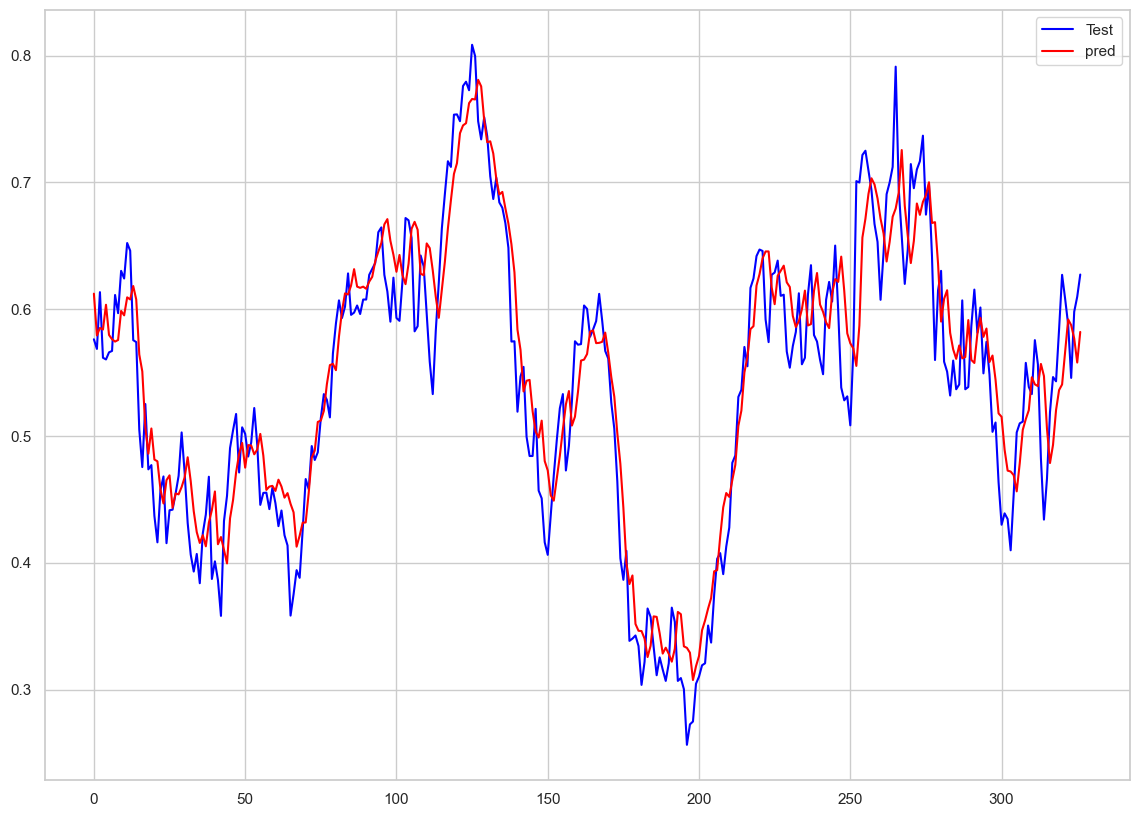

In [34]:
plt.plot(y_test, color = 'blue', label = 'Test')
plt.plot(y_pred, color = 'red', label = 'pred')
plt.legend()
plt.show()

### 6. Calculating Error metrics

In [35]:
def MAPE(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    MAPE = np.nanmean(np.abs((actual - pred) / actual)) * 100
    return MAPE

def MAE(actual, pred):
    MAE = mean_absolute_error(actual, pred)
    return MAE

def RMSE(actual, pred):
    RMSE = mean_squared_error(actual, pred, squared = False)
    return RMSE

In [36]:
MAPE(y_test, y_pred)

6.612625682130095

In [37]:
MAE(y_test, y_pred)

0.033633402464968314

In [38]:
RMSE(y_test, y_pred)

0.04111076779552466

In [39]:
backcandles = 50
X = []
for j in range(19): # range is the number of feature columns you will use
    X.append([])
    for i in range(backcandles, bova11_scaled.shape[0]):
        X[j].append(bova11_scaled[i-backcandles:i, j])

#move axis from 0 to position 2
X = np.moveaxis(X, [0], [2])

X, yi = np.array(X), np.array(bova11_scaled[backcandles:, -1]) # Chosing the last column as the pred. target
y = np.reshape(yi, (len(yi), 1))
    
splitlimit = int(len(X) * 0.9)
x_train, x_test = X[:splitlimit], X[splitlimit+1:]
y_train, y_test = y[:splitlimit], y[splitlimit+1:]

### 7. Tuning the hyperparameters

In [40]:
def LSTM_hyperparameter_tuning(config):
    first_add_layer, second_add_layer, third_add_layer, n_neurons, n_batch_size, dropout, pass_days = config
    combinations = list(itertools.product(first_add_layer, second_add_layer, third_add_layer,
                                         n_neurons, n_batch_size, dropout, pass_days))
    print(combinations)
    print('\n')
    
    hist = []
    
    for i in range(0, len(combinations)):
        
        print(f'{i+1}th combination: \n')
        print('-'* 100)
        
        first_add_layer, second_add_layer, third_add_layer, n_neurons, n_batch_size, dropout, pass_days = combinations[i]
        
        print(combinations[i])
        
        backcandles = pass_days
        X = []
        for j in range(19): # range is the number of feature columns you will use
            X.append([])
            for k in range(backcandles, bova11_scaled.shape[0]):
                X[j].append(bova11_scaled[k-backcandles:k, j])

        #move axis from 0 to position 2
        X = np.moveaxis(X, [0], [2])

        X, yi = np.array(X), np.array(bova11_scaled[backcandles:, -1]) # Chosing the last column as the pred. target
        y = np.reshape(yi, (len(yi), 1))

        splitlimit = int(len(X) * 0.9)
        x_train, x_test = X[:splitlimit], X[splitlimit+1:]
        y_train, y_test = y[:splitlimit], y[splitlimit+1:]
        
        model = Sequential()
        model.add(LSTM(units = n_neurons, return_sequences = True,
                 input_shape = (x_train.shape[1], x_train.shape[2])))
        model.add(Dropout(dropout))
        
        if first_add_layer:
            model.add(LSTM(units = n_neurons, return_sequences = True))
            model.add(Dropout(dropout))
        
        if second_add_layer:
            model.add(LSTM(units = n_neurons, return_sequences = True))
            model.add(Dropout(dropout))
        
        if third_add_layer:
            model.add(LSTM(units = n_neurons, return_sequences = True))
            model.add(Dropout(dropout))
        
        model.add(LSTM(units = n_neurons, return_sequences = False))
        model.add(Dropout(dropout))
        model.add(Dense(units = 1, activation = 'linear'))
        model.compile(optimizer = 'adam', 
                      loss = 'mse', 
                      metrics = [tf.keras.metrics.RootMeanSquaredError()])
        
        es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 7)
        
        file_path = 'best_model.h5'
        
        mc = ModelCheckpoint(file_path, monitor = 'val_loss', mode = 'min', verbose = 1, save_best_only = True)
        
        model.fit(x_train, y_train, 
                  validation_split = 0.1, 
                  epochs = 50, 
                  batch_size = n_batch_size,
                  callbacks = [es, mc], 
                  verbose = 0,
                  shuffle = True)
        train_accuracy = model.evaluate(x_train, y_train, verbose = 0)
        test_accuracy = model.evaluate(x_test, y_test, verbose = 0)
        
        hist.append(list((first_add_layer, second_add_layer, third_add_layer, n_neurons, n_batch_size, dropout,pass_days, train_accuracy, test_accuracy)))
        
        print(f'{str(i)}-th combination = {combinations[i]} \n train accucary: {train_accuracy} and test accuracy: {test_accuracy}')
        print('-' * 100)
        print('-'* 100)
        
    return hist

In [42]:
config = [[False], [False], [False], [256, 128, 64], [16,32],[0.2], [50,100]]

hist = LSTM_hyperparameter_tuning(config)

[(False, False, False, 256, 16, 0.2, 50), (False, False, False, 256, 16, 0.2, 100), (False, False, False, 256, 32, 0.2, 50), (False, False, False, 256, 32, 0.2, 100), (False, False, False, 128, 16, 0.2, 50), (False, False, False, 128, 16, 0.2, 100), (False, False, False, 128, 32, 0.2, 50), (False, False, False, 128, 32, 0.2, 100), (False, False, False, 64, 16, 0.2, 50), (False, False, False, 64, 16, 0.2, 100), (False, False, False, 64, 32, 0.2, 50), (False, False, False, 64, 32, 0.2, 100)]


1th combination: 

----------------------------------------------------------------------------------------------------
(False, False, False, 256, 16, 0.2, 50)

Epoch 1: val_loss improved from inf to 0.00455, saving model to best_model.h5

Epoch 2: val_loss did not improve from 0.00455

Epoch 3: val_loss improved from 0.00455 to 0.00172, saving model to best_model.h5

Epoch 4: val_loss did not improve from 0.00172

Epoch 5: val_loss did not improve from 0.00172

Epoch 6: val_loss improved from 0.00


Epoch 36: val_loss did not improve from 0.00109
Epoch 36: early stopping
3-th combination = (False, False, False, 256, 32, 0.2, 100) 
 train accucary: [0.0006059178267605603, 0.024615397676825523] and test accuracy: [0.0013455254957079887, 0.0366814061999321]
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
5th combination: 

----------------------------------------------------------------------------------------------------
(False, False, False, 128, 16, 0.2, 50)

Epoch 1: val_loss improved from inf to 0.01285, saving model to best_model.h5

Epoch 2: val_loss improved from 0.01285 to 0.00229, saving model to best_model.h5

Epoch 3: val_loss improved from 0.00229 to 0.00169, saving model to best_model.h5

Epoch 4: val_loss improved from 0.00169 to 0.00146, saving model to best_model.h5

Epoch 5: val_loss did not improve from 0.00146




Epoch 1: val_loss improved from inf to 0.00501, saving model to best_model.h5

Epoch 2: val_loss did not improve from 0.00501

Epoch 3: val_loss improved from 0.00501 to 0.00264, saving model to best_model.h5

Epoch 4: val_loss improved from 0.00264 to 0.00172, saving model to best_model.h5

Epoch 5: val_loss did not improve from 0.00172

Epoch 6: val_loss did not improve from 0.00172

Epoch 7: val_loss did not improve from 0.00172

Epoch 8: val_loss did not improve from 0.00172

Epoch 9: val_loss did not improve from 0.00172

Epoch 10: val_loss improved from 0.00172 to 0.00156, saving model to best_model.h5

Epoch 11: val_loss did not improve from 0.00156

Epoch 12: val_loss did not improve from 0.00156

Epoch 13: val_loss did not improve from 0.00156

Epoch 14: val_loss did not improve from 0.00156

Epoch 15: val_loss did not improve from 0.00156

Epoch 16: val_loss did not improve from 0.00156

Epoch 17: val_loss did not improve from 0.00156
Epoch 17: early stopping
8-th combinatio

#### Choosing the Best Model

In [43]:
x_train.shape

(2995, 50, 19)

In [44]:
y_train.shape

(2995, 1)

In [45]:
y_train.shape

(2995, 1)

In [46]:
hist = pd.DataFrame(hist)
hist = hist.sort_values(by= [7], ascending = True)
hist

,0,1,2,3,4,5,6,7,8
3,False,False,False,256,32,0.2,100,"[0.0006059178267605603, 0.024615397676825523]","[0.0013455254957079887, 0.0366814061999321]"
6,False,False,False,128,32,0.2,50,"[0.000704015139490366, 0.026533283293247223]","[0.0017592698568478227, 0.04194365069270134]"
9,False,False,False,64,16,0.2,100,"[0.0007248580805025995, 0.02692318893969059]","[0.0016654124483466148, 0.04080946370959282]"
4,False,False,False,128,16,0.2,50,"[0.0008209468214772642, 0.028652168810367584]","[0.001849859720095992, 0.04300999641418457]"
7,False,False,False,128,32,0.2,100,"[0.0008662798209115863, 0.02943263202905655]","[0.002385309198871255, 0.04883962869644165]"
8,False,False,False,64,16,0.2,50,"[0.0008669572998769581, 0.029444139450788498]","[0.0020277511794120073, 0.04503055661916733]"
11,False,False,False,64,32,0.2,100,"[0.0009149021352641284, 0.03024734929203987]","[0.0017912030452862382, 0.04232260584831238]"
0,False,False,False,256,16,0.2,50,"[0.0010594248306006193, 0.03254880756139755]","[0.001946031698025763, 0.044113848358392715]"
10,False,False,False,64,32,0.2,50,"[0.0010902717476710677, 0.03301926329731941]","[0.0022059420589357615, 0.046967457979917526]"
2,False,False,False,256,32,0.2,50,"[0.0011282999766990542, 0.033590175211429596]","[0.0028719338588416576, 0.053590428084135056]"


In [54]:
print(f'Best Combination: \n first_additional_layer = {hist.iloc[0, 0]}\n second_additional_layer = {hist.iloc[0, 1]}\n third_additional_layer = {hist.iloc[0, 2]}\n n_neurons = {hist.iloc[0, 3]}\n n_batch_size = {hist.iloc[0, 4]}\n dropout = {hist.iloc[0, 5]}\n pass_days = {hist.iloc[0,6]}')

print(f'Results Before Tunning:\n Test Set RMSE: {np.round(results, 4)}\n')
print(f'Results After Tunning:\n Test Set RMSE: {np.round(hist.iloc[0, -2], 4)[1]}\n')
print(f'{np.round((results - hist.iloc[0, -2][1])*100/np.round(results, 4))}% Improvement')

Best Combination: 
 first_additional_layer = False
 second_additional_layer = False
 third_additional_layer = False
 n_neurons = 256
 n_batch_size = 32
 dropout = 0.2
 pass_days = 100
Results Before Tunning:
 Test Set RMSE: 0.0017

Results After Tunning:
 Test Set RMSE: 0.0246

-1349.0% Improvement


In [48]:
hist.iloc[0, :-2]

0    False
1    False
2    False
3      256
4       32
5      0.2
6      100
Name: 3, dtype: object

In [49]:
first_add_layer, second_add_layer, third_add_layer, n_neurons, n_batch_size, dropout, pass_days = list(hist.iloc[0, :-2])

In [50]:
x_train.shape

(2995, 50, 19)

In [ ]:
model = Sequential()
model.add(LSTM(units = n_neurons, 
               return_sequences = True,
               input_shape = (x_train.shape[1],
                             x_train.shape[2])))
model.add(Dropout(dropout))

model.add(LSTM(units = n_neurons, return_sequences = False))
model.add(Dropout(dropout))
model.add(Dense(units = 1, activation = 'linear'))
model.compile(optimizer = 'adam', loss = 'mse')

es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 7)

file_path = 'best_model.h5'

mc = ModelCheckpoint(file_path, monitor = 'val_loss', mode = 'min', verbose = 1, save_best_only = True)

model.fit(x_train, y_train, 
          validation_split = 0.1, 
          epochs = 50, batch_size = n_batch_size,
         callbacks = [es, mc], verbose = 0)


Epoch 1: val_loss improved from inf to 0.00406, saving model to best_model.h5

Epoch 2: val_loss did not improve from 0.00406

Epoch 3: val_loss improved from 0.00406 to 0.00208, saving model to best_model.h5


In [ ]:
y_pred = model.predict(x_test)

plt.plot(y_test, color = 'blue', label = 'Test')
plt.plot(y_pred, color = 'red', label = 'pred')
plt.legend()
plt.show()

In [ ]:
MAPE(y_test, y_pred), MAE(y_test, y_pred), RMSE(y_test, y_pred)